# Preprocessing

In [1]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data=pd.read_csv('banknote.csv', encoding='latin')
print('Shape:', data.shape)

# Printing sample data
# Start observing the Quantitative/Categorical/Qualitative variables
data.head(5)

Shape: (1372, 5)


,variance of Wavelet,skewness of Wavelet,curtosis of Wavelet,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,1.0
1,4.54590,8.1674,-2.4586,-1.46210,1.0
2,3.86600,-2.6383,1.9242,0.10645,1.0
3,3.45660,9.5228,-4.0112,-3.59440,1.0
4,0.32924,-4.4552,4.5718,-0.98880,1.0


In [2]:
for i in range(len(data)):
    if data.iloc[i,-1]==1.0:
        data.iloc[i,-1]=0
    else:
        data.iloc[i,-1]=1

In [3]:
Target=data.columns[-1]
Feature_names=np.array(data.columns)[:-1]
print(Target)
print(Feature_names)

class
['variance of Wavelet' 'skewness of Wavelet' 'curtosis of Wavelet'
 'entropy']


In [4]:
y = data[Target]
X = data.drop(axis=1,labels=Target,inplace=False)

In [5]:
aa=X.nunique()

Continousfeatures=[]
Categoricalfeatures=[]

for i in range(len(Feature_names)):
    if aa[i]>30:
        Continousfeatures.append(Feature_names[i])
    else:
        Categoricalfeatures.append(Feature_names[i])

print(Continousfeatures)
print(Categoricalfeatures)

['variance of Wavelet', 'skewness of Wavelet', 'curtosis of Wavelet', 'entropy']
[]


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,test_size=0.2,random_state=428)



X_train=train.drop(axis=1,labels=Target,inplace=False)
y_train=train[Target]

X_test=test.drop(axis=1,labels=Target,inplace=False)
y_test=test[Target]

In [7]:
for i in Categoricalfeatures:
    X[i].astype("category")
    X_train[i].astype("category")
    X_test[i].astype("category")


# Implemente XGBOOST

In [8]:
##pip install xgboost

In [9]:
import xgboost as xgb

In [10]:
clf = xgb.XGBClassifier(
    n_estimators=50,
    enable_categorical=False,  #  si True, tree_method = "gpu_hist" or "hist" or "approx"
    tree_method="approx",      # "gpu_hist" or "hist" or "approx" or "exact"
    #max_depth,booster,random_state,tree_method
)

clf.fit(X_train, y_train)

prediction=clf.predict(X_test)

import matplotlib.pyplot as plt

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       150
         1.0       1.00      0.98      0.99       125

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

[[150   0]
 [  2 123]]
Accuracy of the model on Testing Sample Data: 0.99


# implemente SHAP

In [11]:
##pip install shap

In [12]:
import shap

In [13]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
np.shape(shap_values)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(1372, 4)

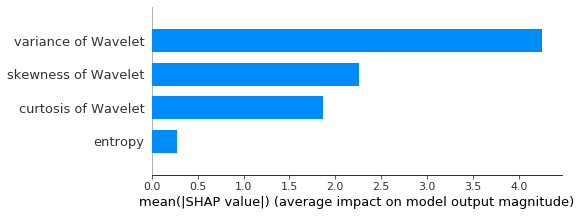

In [14]:
shap.summary_plot(shap_values,X,plot_type="bar")

# try to use different method of combination/reduction of dimension

# PCA

In [15]:
Prediction=clf.predict(X)

explained_variance_ratio: [0.6553466 0.2065836]


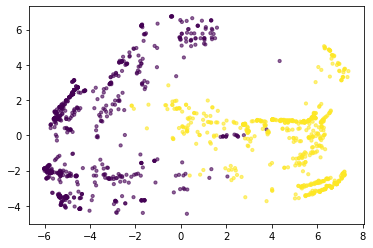

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=500)

data2=pca.fit_transform(shap_values)
print("explained_variance_ratio:",pca.explained_variance_ratio_)
plt.scatter(data2[:,0],data2[:,1], c=Prediction,alpha = 0.6, s=10)



# MDS

In [17]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,
                metric = True, #default True
                dissimilarity='euclidean' # default euclidean
               )

stress: 1295208.7038437845


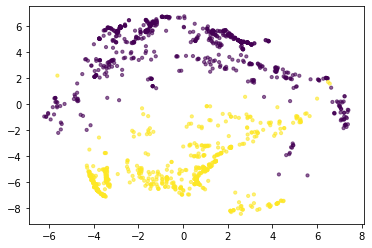

In [18]:
X_mds= embedding.fit_transform(shap_values)
print("stress:",embedding.stress_)
plt.scatter(X_mds[:,0],X_mds[:,1],c=Prediction, alpha = 0.6, s=10)

# UMAP

In [19]:
##pip install umap-learn


In [24]:
import umap


In [25]:
reducer=umap.UMAP(n_components=2)

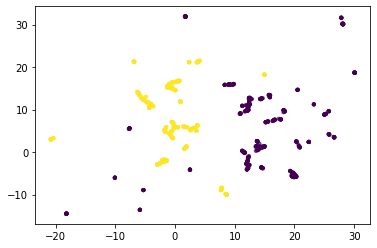

In [26]:
embedding = reducer.fit_transform(shap_values)
plt.scatter(embedding[:,0],embedding[:,1],c=Prediction, alpha = 0.6, s=10)

# t-SNE

In [27]:
##pip install tsne

In [54]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,init='random',learning_rate=200,random_state=0)

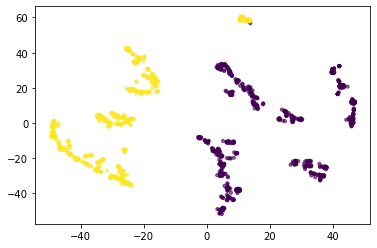

In [55]:
tsne_result = tsne.fit_transform(shap_values)

plt.scatter(tsne_result[:,0],tsne_result[:,1],c=Prediction, alpha = 0.6, s=10)

# ==============================================
# we choose the result of t-SNE
# Clustering

## dbscan (need to choose proper value of epsilon and M)

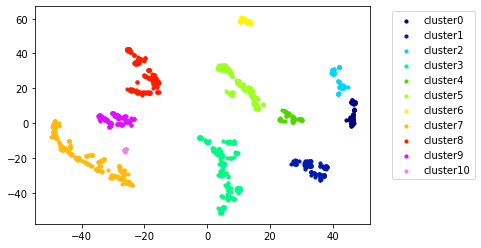

In [56]:
from sklearn.cluster import DBSCAN

epsilon = 5
M = 5

result_dbscan = DBSCAN(eps = epsilon, min_samples = M+1,algorithm='brute').fit_predict(tsne_result)


a=[]
for i in range(len(set(result_dbscan))):
    a.append([[],[]])

for i in range(len(data)):
        a[result_dbscan[i]][0].append(tsne_result[i][0])
        a[result_dbscan[i]][1].append(tsne_result[i][1]) 
        
import matplotlib
import matplotlib.cm as cm

N=len(np.unique(result_dbscan))
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.9,N)]

fig=plt.figure()
ax = fig.add_subplot(111)
for i in range(N):
    ax.scatter(a[i][0],a[i][1],s=10,color=colors[i],label='cluster'+str(i))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


## we choose cluster1

number of points: 110
average prediction: 0.0


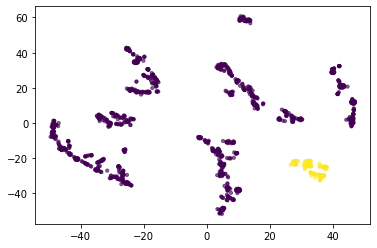

In [57]:
clusterN=1

label_for_skope=np.zeros(len(Prediction))
avp=0
for i in range(len(Prediction)):
    if result_dbscan[i]==clusterN:
        label_for_skope[i]=1
        avp+=Prediction[i]

print("number of points:", int(label_for_skope.sum()))
print("average prediction:",avp/label_for_skope.sum())   

plt.scatter(tsne_result[:,0],tsne_result[:,1],c=label_for_skope, alpha = 0.6, s=10)

### show the dual segment in the value space

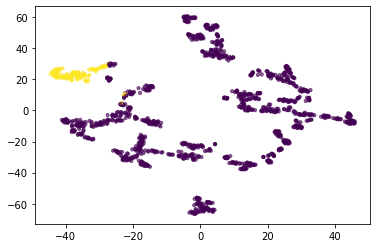

In [58]:
from sklearn.preprocessing import StandardScaler

X_2=StandardScaler().fit_transform(X)


tsne=TSNE(n_components=2,init='random',learning_rate=200,random_state=0)
tsne_result2=tsne.fit_transform(X_2)

plt.scatter(tsne_result2[:,0],tsne_result2[:,1],c=label_for_skope, alpha = 0.6, s=10)

### give the rules (skope-rules on the explication space)

In [59]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

skp = SkopeRules(
                 max_depth=3,
                 max_depth_duplication=2,
                 n_estimators=50,
                 precision_min=0.5,
                 recall_min=0.05,
                 feature_names=Feature_names
                 )
 
skp.fit(X, label_for_skope)
print("Rules")
print()
for rule in skp.rules_:
    print("rule:" ,rule[0])
    print("precision:",rule[1][0])
    print("recall:", rule[1][1])
    print()
print(20*'=')
print()

Rules

rule: variance of Wavelet > 1.7583999633789062 and skewness of Wavelet <= -0.7170150279998779
precision: 1.0
recall: 1.0

rule: variance of Wavelet > 1.7621999979019165 and skewness of Wavelet > -2.0257999897003174 and curtosis of Wavelet > 5.0178000926971436
precision: 0.888888888888889
recall: 0.06029349957971421




## kmeans

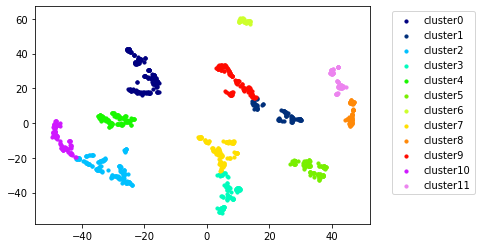

In [60]:
from sklearn.cluster import KMeans

N_clusters=12 # please choose 

kmeans = KMeans(n_clusters=N_clusters, random_state=7)

result_kmeans=kmeans.fit_predict(tsne_result)

a=[]
for i in range(N_clusters):
    a.append([[],[]])

for i in range(len(Prediction)):
        a[result_kmeans[i]][0].append(tsne_result[i][0])
        a[result_kmeans[i]][1].append(tsne_result[i][1])
        

N=N_clusters
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.9,N)]

fig=plt.figure()
ax = fig.add_subplot(111)
for i in range(N_clusters):
    ax.scatter(a[i][0],a[i][1],color=colors[i],s=10,label='cluster'+str(i))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## we choose cluster1 to use Skope-rules 

number of points: 100
average prediction: 0.0


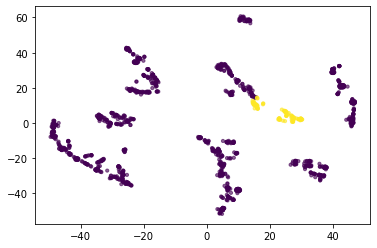

In [61]:
clusterN=1

label_for_skope=np.zeros(len(Prediction))
avp=0
for i in range(len(Prediction)):
    if result_kmeans[i]==clusterN:
        label_for_skope[i]=1
        avp+=Prediction[i]

print("number of points:", int(label_for_skope.sum()))
print("average prediction:",avp/label_for_skope.sum()) 

plt.scatter(tsne_result[:,0],tsne_result[:,1],c=label_for_skope, alpha = 0.6, s=10)

### show the rule

In [62]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

skp = SkopeRules(
                 max_depth=3,     ###  change this to reach high precision 
                 max_depth_duplication=2,
                 n_estimators=50,    ###  change this to reach high precision
                 precision_min=0.3,
                 recall_min=0.05,
                 feature_names=Feature_names
                 )
 
skp.fit(X, label_for_skope)
print("Rules")
print()
for rule in skp.rules_:
    print("rule:" ,rule[0])
    print("precision:",rule[1][0])
    print("recall:", rule[1][1])
    print()
print(20*'=')
print()

Rules

rule: skewness of Wavelet <= 7.925349950790405 and skewness of Wavelet > 5.306650161743164 and curtosis of Wavelet > -1.4226499795913696
precision: 0.7614678899082569
recall: 0.9540229885057471

rule: variance of Wavelet > 0.31762999296188354 and skewness of Wavelet <= 7.631500005722046 and skewness of Wavelet > 5.312849998474121
precision: 0.7498483929654336
recall: 0.8712349397590362


